In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/chinook/Chinook_Sqlite.sqlite


In [2]:
!pip install langchain langchain_community langgraph langchain_groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.9/151.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.8/442.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.66
    Uninstalling langchain-core-0.3.66:
      Successfully uninstalled langchain-core-0.3.66


In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_groq = user_secrets.get_secret("groq_key")
secret_value_LangSmith = user_secrets.get_secret("LangSmith_tutorial_key")


In [4]:
import os
if not os.environ.get("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = secret_value_groq
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = secret_value_LangSmith
    os.environ["LANGSMITH_TRACING"] = "true"

In [5]:

from langchain.chat_models import init_chat_model
llm = init_chat_model("llama3-8b-8192", model_provider="groq")

In [6]:
from langchain_community.utilities import SQLDatabase
db = SQLDatabase.from_uri("sqlite:////kaggle/input/chinook/Chinook_Sqlite.sqlite")
print(db.dialect)
print(db.get_usable_table_names())
db.run("Select * from Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [7]:
from typing_extensions import TypedDict

class State(TypedDict):
    question: str
    query: str
    query_result: str
    answer: str
    

In [8]:
db.get_table_names()

/tmp/ipykernel_13/4073026401.py:1: LangChainDeprecationWarning: The method `SQLDatabase.get_table_names` was deprecated in langchain-community 0.0.1 and will be removed in 1.0. Use :meth:`~get_usable_table_names` instead.
  db.get_table_names()


['Album',
 'Artist',
 'Customer',
 'Employee',
 'Genre',
 'Invoice',
 'InvoiceLine',
 'MediaType',
 'Playlist',
 'PlaylistTrack',
 'Track']

In [9]:
from langchain_core.prompts import ChatPromptTemplate
system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""
user_prompt = "Question: {input}"
query_prompt_template = ChatPromptTemplate(
    [("system",system_message),("user",user_prompt)]
)
for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


In [10]:
from typing_extensions import Annotated
class QueryOutput(TypedDict):
    """Generate SQL query"""
    query: Annotated[str,...,"Syntactically valid SQL query"]

def write_query(state: State):
    """Generate SQL query to fetch information"""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k":8,
            "table_info": db.get_table_info(),
            "input": state['question'],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query":result["query"]}

In [11]:
write_query({"question":"How many employees are there?"})

{'query': 'SELECT COUNT(*) FROM Employee;'}

# Execute query

In [12]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"query_result":execute_query_tool.invoke(state["query"])}

In [13]:
execute_query({"query":'SELECT COUNT(*) FROM Employee'})

{'query_result': '[(8,)]'}

## Generate answer

In [14]:
def generate_answer(state:State):
    """Generates result based on the query and query_output"""
    prompt = (
        "Given the following user question, corresponding to a SQL query, "
        "and SQL query result, answer the user question based on SQL query and SQL query result.\n\n"
        f"Question:{state['question']}\n\n"
        f"Query:{state['query']}\n"
        f"SQL query result:{state['query_result']}"
    )
    answer=llm.invoke(prompt)
    return {"answer":answer.content}

# Orchestrating with langgraph

In [15]:
from langgraph.graph import START,StateGraph

graph_builder = StateGraph(State).add_sequence([write_query,execute_query,generate_answer])
graph_builder.add_edge(START,"write_query")
graph = graph_builder.compile()

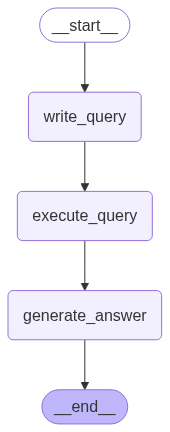

In [16]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) FROM Employee'}}
{'execute_query': {'query_result': '[(8,)]'}}
{'generate_answer': {'answer': "Based on the SQL query result, the answer to the user's question is:\n\nThere are 8 employees."}}
